<a href="https://colab.research.google.com/github/TomPhanAnh/FPT-Data-Science/blob/main/Assignment_1_DSP304.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will try the process of implementing CNN with Keras in order to classify images.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data, before visualize and preprocess it.

III.  **We'll try a simple CNN model** and then we will evaluate its performances.

IV.   **Finally,** we'll use techniques such as data augmentation, learning rate decay and dropout to increase our test F1.

# I. Let import all useful packages.

In [ ]:
!pip install keras==2.6.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_addons as tfa
import os
import random
import datetime
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn

**Task 1:** Setting Fre GPU in this Google Colab notebook.

[*Hint.*](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.

[*Hint.*](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=eikfzi8ZT_rW)

In [ ]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Task 3**: Copy the zip dataset from Google Drive into Colab, then unzip it and finally remove the zip file to free up space.

[*Hint.*](https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf)

In [ ]:
## TYPE YOUR CODE for task 3 here:
!unzip "/content/drive/MyDrive/Data FPT/Old dataset/image-classification.zip"

Archive:  /content/drive/MyDrive/Data FPT/Old dataset/image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# II. Load the data.

## About dataset.
This is image data of Natural Scenes around the world.
This Data contains around 25k images of size 150x150 distributed under 6 categories. {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test.


Now, We need to prepare our data to feed into the model. There is a builtin method in Keras that can extract your images from folder.

Following is the gernalized functions used to extract data from the directory.

In [ ]:
# Here's our 6 categories that we have to classify.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {'buildings': 0,
                    'forest' : 1,
                    'glacier' : 2,
                    'mountain' : 3,
                    'sea' : 4,
                    'street' : 5
                    }
nb_classes = 6

## Loading the Data

**Task 4:** We have to write a load_data function that load the training and test data ( which contain images and the labels) from the folder.

* **Load_data** function return **train_set** and **test_set**. Each set contains **images and labels**.
* Apply 2 augmentation transformations (**shear_range** = 0.2, **zoom_range** = 0.2), shuffle with seed = 8 and rescaling function( to [0, 1]) to **train_set.**
* Apply rescaling funtion to [0, 1]  to **test_set**, no shuffle.
* Batch size = 32.



[*Hint.*](https://keras.io/preprocessing/image/)


In [ ]:
def load_data(data_directories):
  batch_size = 32

# this is the augmentation configuration we will use for training
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
  test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
  train_generator = train_datagen.flow_from_directory(
        data_directories[0],  # this is the target directory
        target_size=(32, 32),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode = "categorical")  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
  validation_generator = test_datagen.flow_from_directory(
         data_directories[1],
        target_size=(32,32),
        batch_size=batch_size,
        class_mode = "categorical")
  
  return train_generator, validation_generator


data_directories = ['/content/seg_train/seg_train', '/content/seg_test/seg_test/']
train_ds, test_ds = load_data(data_directories)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Let's explore the dataset.
We can, for example, ask ourselves:

* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.


**Task 5:** Print out:

*  Number of training examples.
*  Number of testing examples.
* Size of each image.



In [ ]:
from glob import glob
import pathlib

In [ ]:
## TYPE YOUR CODE for task 5 here:
train_dir = pathlib.Path("/content/seg_train/seg_train")
print("The number of image - Training", len(list(train_dir.glob('*/*.jpg'))))
test_dir = pathlib.Path("/content/seg_test/seg_test")
print("The number of image - Testing", len(list(test_dir.glob("*/*.jpg"))))

for image_batchs, labels_batch in train_ds:
  print("Size of image:{}".format(image_batchs.shape))
  print("Size of image;{}".format(labels_batch.shape))
  break

The number of image - Training 14034
The number of image - Testing 3000
Size of image:(32, 32, 32, 3)
Size of image;(32, 6)


**Task 6:** Plot a pie chart of the proportion of each class.
You need to show the name and proportion of each class on the pie chart.

*Hint:* [plot.pie](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)

In [ ]:
number = []
for i in class_names:
  path = "/content/seg_train/seg_train/" + i
  number.append(len(os.listdir(path)))

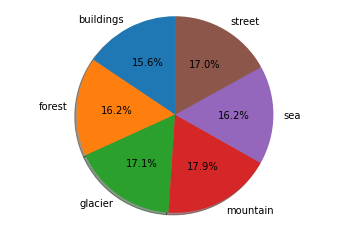

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_pie(train_dataset, class_names):
    ## TYPE YOUR CODE for task 6 here:
    number = []
    for i in class_names:
      path = "/content/seg_train/seg_train/" + i
      number.append(len(os.listdir(path)))

    fig1, ax1 = plt.subplots()
    ax1.pie(number, labels=class_names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')
    return ax1

plot_pie(train_ds, class_names)

**Task 7**: Display the 36 random images from the training set.

* Each class contain 6 random images.
* Bellow the image, show the class it belongs to.

*Hint*: [plot.imshow](https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_demo.html)

In [ ]:
# def visualize_image(train_directory):
#     ## TYPE YOUR CODE for task 7 here:
#     plt.figure(figsize = (15,15))
#     for images, labels in train_ds:
#       for i in range(36):
#         try:
#           ax = plt.subplot(6,6,i+1)
#           plt.imshow(images[i].numpy().astype("uint8"))
#           plt.title(class_names[labels[i]])
#           plt.axis("off")
#         except:
#           pass

# train_directory = 'seg_train/seg_train/'
# visualize_image(train_directory)

# III. Modelling
## There are some steps we need to finish:
* Build the model.

* Compile the model.

* Train / fit the data to the model.

* Evaluate the model on the testing set.


## Build the model
We can build an easy model composed of different layers such as:

* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

* [MaxPooling2D:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) The images get smaller sized.

* [Flatten:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

* [Relu:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU) given a value x, returns max(x, 0).

* [Softmax:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax) 6 neurons, probability that the image belongs to one of the classes.

* [Dense.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

* [Dropout.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

**Task 8**: Buil a model, which contain these layers:
- Layer 1: Conv2D, 8 filters, kernel_size = (3, 3), activation = 'relu', input_shape = image_shape, same padding.
- Layer 2: Conv2D, 16 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 3: MaxPooling2D, pooling size = (2, 2).
- Layer 4: Conv2D, 32 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 5: Conv2D, 64 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 6: MaxPooling2D, pooling size = (3, 3).
- Layer 7: Conv2D, 128 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 8: Conv2D, 256 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 9: MaxPooling2D, pooling size = (5, 5).
- Layer 10: Flatten.
- Layer 11: Dense with number of unit = 100, activation = 'relu'.
- Layer 12: Dropout with probs = 0.5.
- Layer 13: Final dense with number of unit = number of class, activation = 'softmax'.



All the Conv2D and Dense layers are followed by a Batch Norm layer with customized configuration excepts from the last dense layer:

- momentum=0.95 
- epsilon=0.005
- beta_initializer = RandomNormal with mean = 0 and stddev = 0.05
- gammaa_initializer = Constant with value = 0.9


In [ ]:
def create_model():
    '''
    Return: 
        CNN model with 13 layers.
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8,  (3,3), activation = "relu", input_shape = image_batchs.shape[1:], padding = "same"),
        tf.keras.layers.Conv2D(16, (3,3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128,(3,3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256,(3,3), activation = "relu", padding = "same"),
        tf.keras.layers.MaxPooling2D(pool_size = (5,5)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 100, activation = "relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation = "softmax")
        ])
    ## TYPE YOUR CODE for task 8 here:

    return model
model = create_model()

**Task 9:** Compile the model. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-4, categorical-crossentroy loss and "[F1 score](https://github.com/tensorflow/addons/issues/825)" as metric.
* Print out the model F1.

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  predicted_positves = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives/ (predicted_positves + K.epsilon())
  recall    = true_positives/ (possible_positives + K.epsilon())
  f1_val    =  2*(precision*recall)/(precision + recall + K.epsilon())
  return f1_val

def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 9 here:
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy',get_f1]) # model compile
    return model

model = optimize(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 256)         0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Task 10**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best F1 after each epoch. 
* Create the [ReduceLROnPlateau callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) to reduce learning rate when the validation F1 score has stopped improving with the factor of 0.1 and patience = 2.

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K


def get_call_backs(path, logs_name):
  filepath = "/content/" + path
  checkpoint = ModelCheckpoint(filepath = filepath,
                               monitor = "val_f1_score",
                               verbose = 1,
                               save_best_only = False,
                               save_weights_only = True,
                               mode = max)
  lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.1,
                                                    patience = 2,
                                                    min_lr = 1e-4)
  log = TensorBoard(log_dir = logs_name)
  return [lr_reducer, checkpoint, log]

In [ ]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 10 here:
    callbacks_list = get_call_backs(checkpoint_name, logs_name)
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callback_model(checkpoint_name, logs_name)

**Task 11:** Train the model.

**Requirement:** 
* Train the model with 10 epochs, generator = train_dataset, validataion_data = test_dataset.
* Return the model with best-checkpoint weights.

*Hint:*
[Fit](https://keras.io/models/sequential/#fit_generator) the model first, then reload the model ([load_model function](https://keras.io/getting-started/faq/)) with best-checkpoint weights.

In [ ]:
batch_size = 8
model.fit_generator(
        train_ds,
        steps_per_epoch  = 2000 // batch_size,
        epochs= 10,
        validation_data  = test_ds,
        validation_steps = 800 // batch_size)

model.save_weights('first_try.h5') 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 13s 47ms/step - loss: 1.0758 - accuracy: 0.5780 - get_f1: 0.5065
Epoch 2/10
250/250 [==============================] - 12s 46ms/step - loss: 1.0257 - accuracy: 0.6094 - get_f1: 0.5356
Epoch 3/10
250/250 [==============================] - 13s 52ms/step - loss: 0.9735 - accuracy: 0.6325 - get_f1: 0.5760
Epoch 4/10
250/250 [==============================] - 12s 48ms/step - loss: 0.9427 - accuracy: 0.6429 - get_f1: 0.5905
Epoch 5/10
250/250 [==============================] - 12s 48ms/step - loss: 0.9147 - accuracy: 0.6634 - get_f1: 0.6137
Epoch 6/10
250/250 [==============================] - 12s 47ms/step - loss: 0.9100 - accuracy: 0.6615 - get_f1: 0.6122
Epoch 7/10
250/250 [==============================] - 12s 47ms/step - loss: 0.8768 - accuracy: 0.6783 - get_f1: 0.6332
Epoch 8/10
250/250 [==============================] - 14s 55ms/step - loss: 0.8632 - accuracy: 0.6851 - get_f1: 0.6426
Epoch 9/10
250/250 [============================

**Task 12**: [Show the tensorboard](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) in the notebook.

In [ ]:
## TYPE YOUR CODE for task 12 here:
#!kill 685
%tensorboard -- logdir logs

UsageError: Line magic function `%tensorboard` not found.


**Task 13:** Prediction on test set.
* Complete the get_prediction_classes function.
* Print out the test F1. 

In [ ]:
def get_prediction_classes(model, prediction_dataset):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    preds = model.predict(prediction_dataset)
    groundtruth = np.argmax(preds, axis=1) 
    return preds, groundtruth
preds, groundtruth = get_prediction_classes(model, test_ds)

array([3, 2, 5, ..., 2, 4, 1])

In [ ]:
groundtruth

array([3, 2, 5, ..., 2, 4, 1])

**Task 14:** Perform the predicted result on test set using confusion matrix.
Remember to show the class name in the confusion matrix. 

In [ ]:
test_ds.labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

<Figure size 1080x1080 with 0 Axes>

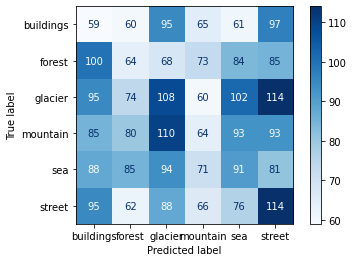

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


y_pred = groundtruth
y_test = test_ds.labels
labels = list(test_ds.class_indices.keys())

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

**Task 15**: Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Play around with CNN, Dense and Dropoutlayers (add/# units/etc).
* Increase data augmentation transformations.
* Try to use a [pretrained model](https://www.tensorflow.org/api_docs/python/tf/keras/applications) on Keras.

Requirement: The val_best_F1 should be higher than 87%.

In [ ]:
## TYPE YOUR CODE for task 15 here:
batch_size = 8
model.fit_generator(
        train_ds,
        steps_per_epoch  = 2000 // batch_size,
        epochs= 10,
        validation_data  = test_ds,
        validation_steps = 800 // batch_size)